# sentinment analysis using roberta model from hugging-face🤗

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



In [2]:
csv_folder = 'F:/innomatics/sentiment_analysis_project/reviews_data_dump/reviews_badminton/data.csv'

df = pd.read_csv(csv_folder)

df.head()

,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text,Ratings
0,Kamal Suresh,Nice product,"Certified Buyer, Chirakkal",889.0,64.0,Feb 2021,"Nice product, good quality, but price is now r...",4
1,Flipkart Customer,Don't waste your money,"Certified Buyer, Hyderabad",109.0,6.0,Feb 2021,They didn't supplied Yonex Mavis 350. Outside ...,1
2,A. S. Raja Srinivasan,Did not meet expectations,"Certified Buyer, Dharmapuri",42.0,3.0,Apr 2021,Worst product. Damaged shuttlecocks packed in ...,1
3,Suresh Narayanasamy,Fair,"Certified Buyer, Chennai",25.0,1.0,NaN,"Quite O. K. , but nowadays the quality of the...",3
4,ASHIK P A,Over priced,NaN,147.0,24.0,Apr 2016,Over pricedJust â?¹620 ..from retailer.I didn'...,1


In [3]:
df.shape

(8518, 8)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8518 entries, 0 to 8517
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Reviewer Name    8508 non-null   object 
 1   Review Title     8508 non-null   object 
 2   Place of Review  8468 non-null   object 
 3   Up Votes         8508 non-null   float64
 4   Down Votes       8508 non-null   float64
 5   Month            8053 non-null   object 
 6   Review text      8510 non-null   object 
 7   Ratings          8518 non-null   int64  
dtypes: float64(2), int64(1), object(5)
memory usage: 532.5+ KB


## quick EDA

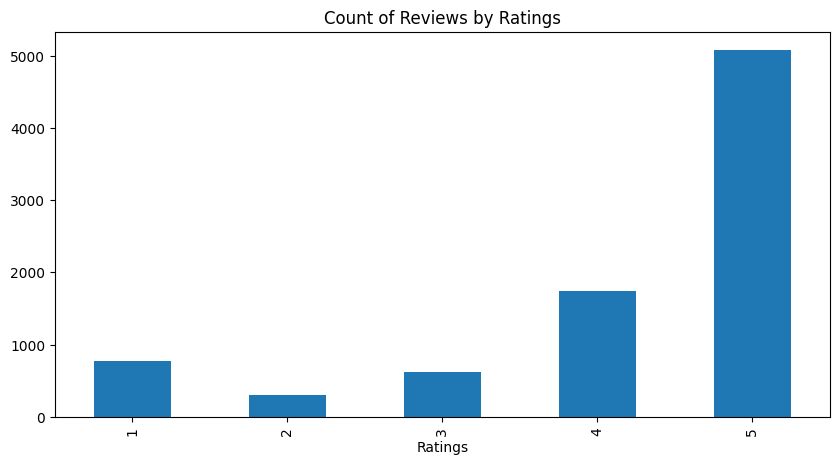

In [5]:
ax = df['Ratings'].value_counts().sort_index().plot(
    kind = 'bar',
    title = 'Count of Reviews by Ratings',
    figsize = (10, 5))


## Model building

In [6]:
from tqdm.notebook import tqdm
import torch
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL).to(device)

C:\Users\ishaq\.conda\envs\pytorch\Lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect t

In [8]:
example = df['Review text'][45]
example

"I've Received 6 duplicate n cheapest balls ,kept inside a broken box, which it was done deleberately. Worst experience, I've ever had with Flipkart. Can buy anything, except badminton yonex mavis 350.READ MORE"

In [9]:
#example run for the model for sentiment analysis

encoded_text = tokenizer(example, return_tensors='pt').to(device)
output = model(**encoded_text)
scores = output[0][0].detach().cpu().numpy()
scores = softmax(scores)
scores_dict = {
    'neg' : scores[0],
    'neu' : scores[1],
    'pos' : scores[2]
}

print('sentiment for example string are : ', scores_dict)

sentiment for example string are :  {'neg': 0.9298171, 'neu': 0.06410296, 'pos': 0.0060799397}


## making inference on our dataset 

In [10]:
def sentiment_scores(text):
    '''
    predict sentiment score using roberta model on torch
    '''
    #cpu code
    # encoded_text = tokenizer(text, return_tensors='pt')
    # output = model(**encoded_text)
    # scores = output[0][0].detach().numpy()
    # scores = softmax(scores)

    #gpu code
    encoded_text = tokenizer(text, return_tensors='pt').to(device)
    with torch.no_grad():
        output = model(**encoded_text)
    scores = output.logits[0].cpu().numpy()
    scores = softmax(scores)
    scores_dict = {
        'neg' : scores[0],
        'neu' : scores[1],
        'pos' : scores[2]
    }
    return scores_dict

#iterate and process our dataset

res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Review text']
        id = i
        result = sentiment_scores(text)
        res[id] = result
    except Exception as e:
        print(f"broke for id: {id}")
    

  0%|          | 0/8518 [00:00<?, ?it/s]

broke for id: 8510
broke for id: 8511
broke for id: 8512
broke for id: 8513
broke for id: 8514
broke for id: 8515
broke for id: 8516
broke for id: 8517


In [11]:
results_df = pd.DataFrame(res)
results_df = results_df.T
results_df.head()

,neg,neu,pos
0,0.584041,0.309843,0.106117
1,0.809329,0.181981,0.008690
2,0.943245,0.050441,0.006314
3,0.686786,0.271718,0.041496
4,0.759788,0.228580,0.011632


In [12]:
results_df.loc[46].sum()

1.0

In [13]:
results_df.shape

(8510, 3)

In [14]:
df.shape

(8518, 8)

### The difference in shape is due to some nan values at the end

In [15]:
results_df = results_df.join(df, how='right')
results_df = results_df.dropna()
results_df.head()

,neg,neu,pos,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text,Ratings
0,0.584041,0.309843,0.106117,Kamal Suresh,Nice product,"Certified Buyer, Chirakkal",889.0,64.0,Feb 2021,"Nice product, good quality, but price is now r...",4
1,0.809329,0.181981,0.008690,Flipkart Customer,Don't waste your money,"Certified Buyer, Hyderabad",109.0,6.0,Feb 2021,They didn't supplied Yonex Mavis 350. Outside ...,1
2,0.943245,0.050441,0.006314,A. S. Raja Srinivasan,Did not meet expectations,"Certified Buyer, Dharmapuri",42.0,3.0,Apr 2021,Worst product. Damaged shuttlecocks packed in ...,1
5,0.007749,0.038283,0.953968,Baji Sankar,Mind-blowing purchase,"Certified Buyer, Hyderabad",173.0,45.0,Oct 2018,Good quality product. Delivered on time.READ MORE,5
6,0.003935,0.013579,0.982486,Flipkart Customer,Must buy!,"Certified Buyer, Doom Dooma",403.0,121.0,Jan 2020,BEST PURCHASE It is a good quality and is more...,5


In [16]:
results_df['pos'][0] - results_df['neg'][0]

-0.47792417

In [17]:
df['Review text'][0]

'Nice product, good quality, but price is now rising which is a bad sign. 800-850 was an affordable price, especially when we play everyday. So kindly help us out in terms of the price. Thank You.READ MORE'

In [18]:
#saving the tokenizer and model in local directory

model.save_pretrained("model")
tokenizer.save_pretrained("model")

('model\\tokenizer_config.json',
 'model\\special_tokens_map.json',
 'model\\vocab.json',
 'model\\merges.txt',
 'model\\added_tokens.json',
 'model\\tokenizer.json')